# Assignment 1: Hidden Markov Model
### Author: Jacopo Raffi

## Preprocessing data
Interpolation when possible, otherwise use same hour value of the previous day

In [64]:
import pandas as pd
import hmmlearn.hmm as hmm
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

data = pd.read_csv("./data/AirQualityUCI.csv", sep=';')
data = data[['Date', 'Time', 'C6H6(GT)']] # for the assignment just need one sensor column

data = data.replace(',', '.', regex=True) # need to do this to convert numbers into float (values are written with ',' and not '.')
data['C6H6(GT)'] = data['C6H6(GT)'].astype(float)

n_missing_values = len(data[data['C6H6(GT)'] == -200])
first_missing_value = data[data['C6H6(GT)'] == -200].index[0]

print(f'Number of missing values: {n_missing_values}\nIndex of the first missing value: {first_missing_value}')

# Data Preprocessing
seq = data['C6H6(GT)'].to_numpy()
for i, elem in enumerate(seq):
    if elem == -200:
        if seq[i+1] == -200 or seq[i-1] == -200:
            seq[i] = seq[i - 24] # same hour day before
        else:
            seq[i] = mean([seq[i-1], seq[i+1]])

data['C6H6(GT)'] = seq

Number of missing values: 366
Index of the first missing value: 524


## HMM training
### Gaussian vs Mixture of Gaussian

To select number of states use model selection (quite naive only 4 number of states)

In [65]:
seq = data['C6H6(GT)'].to_numpy()
seq = seq.reshape(-1, 1) # reshape needed for hmmlearn, 1D sequence must be in this form: [[1], [2], [3]] 
split_size = int(len(seq) * 0.25)

tr_seq = seq[:-split_size] # 75 % for traing set
val_seq = seq[-split_size:] # 25 % for validation set

results = {'Gaussian Tr Score': [],
           'Gaussian Val Score': [],
           'Gaussian Converged': [],
           'Mix Gaussian Tr Score': [],
           'Mix Gaussian Val Score': [],
           'Mix Gaussian Converged': [] }

h_states = [2, 3, 5, 7]

for state in h_states:
    gauss_model = hmm.GaussianHMM(n_components=state, n_iter=1000)
    mix_gauss_model = hmm.GMMHMM(n_components=state, n_iter=1000, n_mix=2)

    gauss_model.fit(tr_seq)
    mix_gauss_model.fit(tr_seq)

    results['Gaussian Tr Score'].append(gauss_model.score(tr_seq))
    results['Gaussian Val Score'].append(gauss_model.score(val_seq))
    results['Gaussian Converged'].append(gauss_model.monitor_.converged)

    results['Mix Gaussian Tr Score'].append(mix_gauss_model.score(tr_seq))
    results['Mix Gaussian Val Score'].append(mix_gauss_model.score(val_seq))
    results['Mix Gaussian Converged'].append(mix_gauss_model.monitor_.converged)

df = pd.DataFrame(results, index=h_states)
df.index.name = "Number of States"


In [66]:
df

,Gaussian Tr Score,Gaussian Val Score,Gaussian Converged,Mix Gaussian Tr Score,Mix Gaussian Val Score,Mix Gaussian Converged
Number of States,,,,,,
2,-24302.743380,-7883.351192,True,-20757.616569,-6506.822315,True
3,-20055.438986,-6251.777317,True,-19640.949259,-6083.277204,True
5,-19020.900788,-5903.977596,True,-18508.176019,-5775.583869,True
7,-18131.788582,-5741.921683,True,-18016.660560,-5548.095769,True


In [67]:
mix_gauss_model = hmm.GMMHMM(n_components=7, n_iter=1000, n_mix=2)
mix_gauss_model.fit(seq)

GMMHMM(covars_prior=array([[[-1.5],
        [-1.5]],

       [[-1.5],
        [-1.5]],

       [[-1.5],
        [-1.5]],

       [[-1.5],
        [-1.5]],

       [[-1.5],
        [-1.5]],

       [[-1.5],
        [-1.5]],

       [[-1.5],
        [-1.5]]]),
       covars_weight=array([[[0.],
        [0.]],

       [[0.],
        [0.]],

       [[0.],
        [0.]],

       [[0.],
        [0.]],

       [[0.],
        [0.]],

       [[0.],
        [0.]],

       [[0.],
        [0.]]]),
       means_prior=array([[[0.],
        [0.]],

       [[0.],
        [0.]],

       [[0.],
        [0.]],

       [[0.],
        [0.]],

       [[0.],
        [0.]],

       [[0.],
        [0.]],

       [[0.],
        [0.]]]),
       means_weight=array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]]),
       n_components=7, n_iter=1000, n_mix=2,
       weights_prior=array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]]))

## Optimal State Assignment

In [68]:
subseq_size = int(len(seq) * 0.25)
subseq = seq[-subseq_size:] # last 25 % of the sequence
v_log_prob, v_states = mix_gauss_model.decode(subseq, algorithm='viterbi')
mps_log_prob, mps_states = mix_gauss_model.decode(subseq, algorithm='map') 

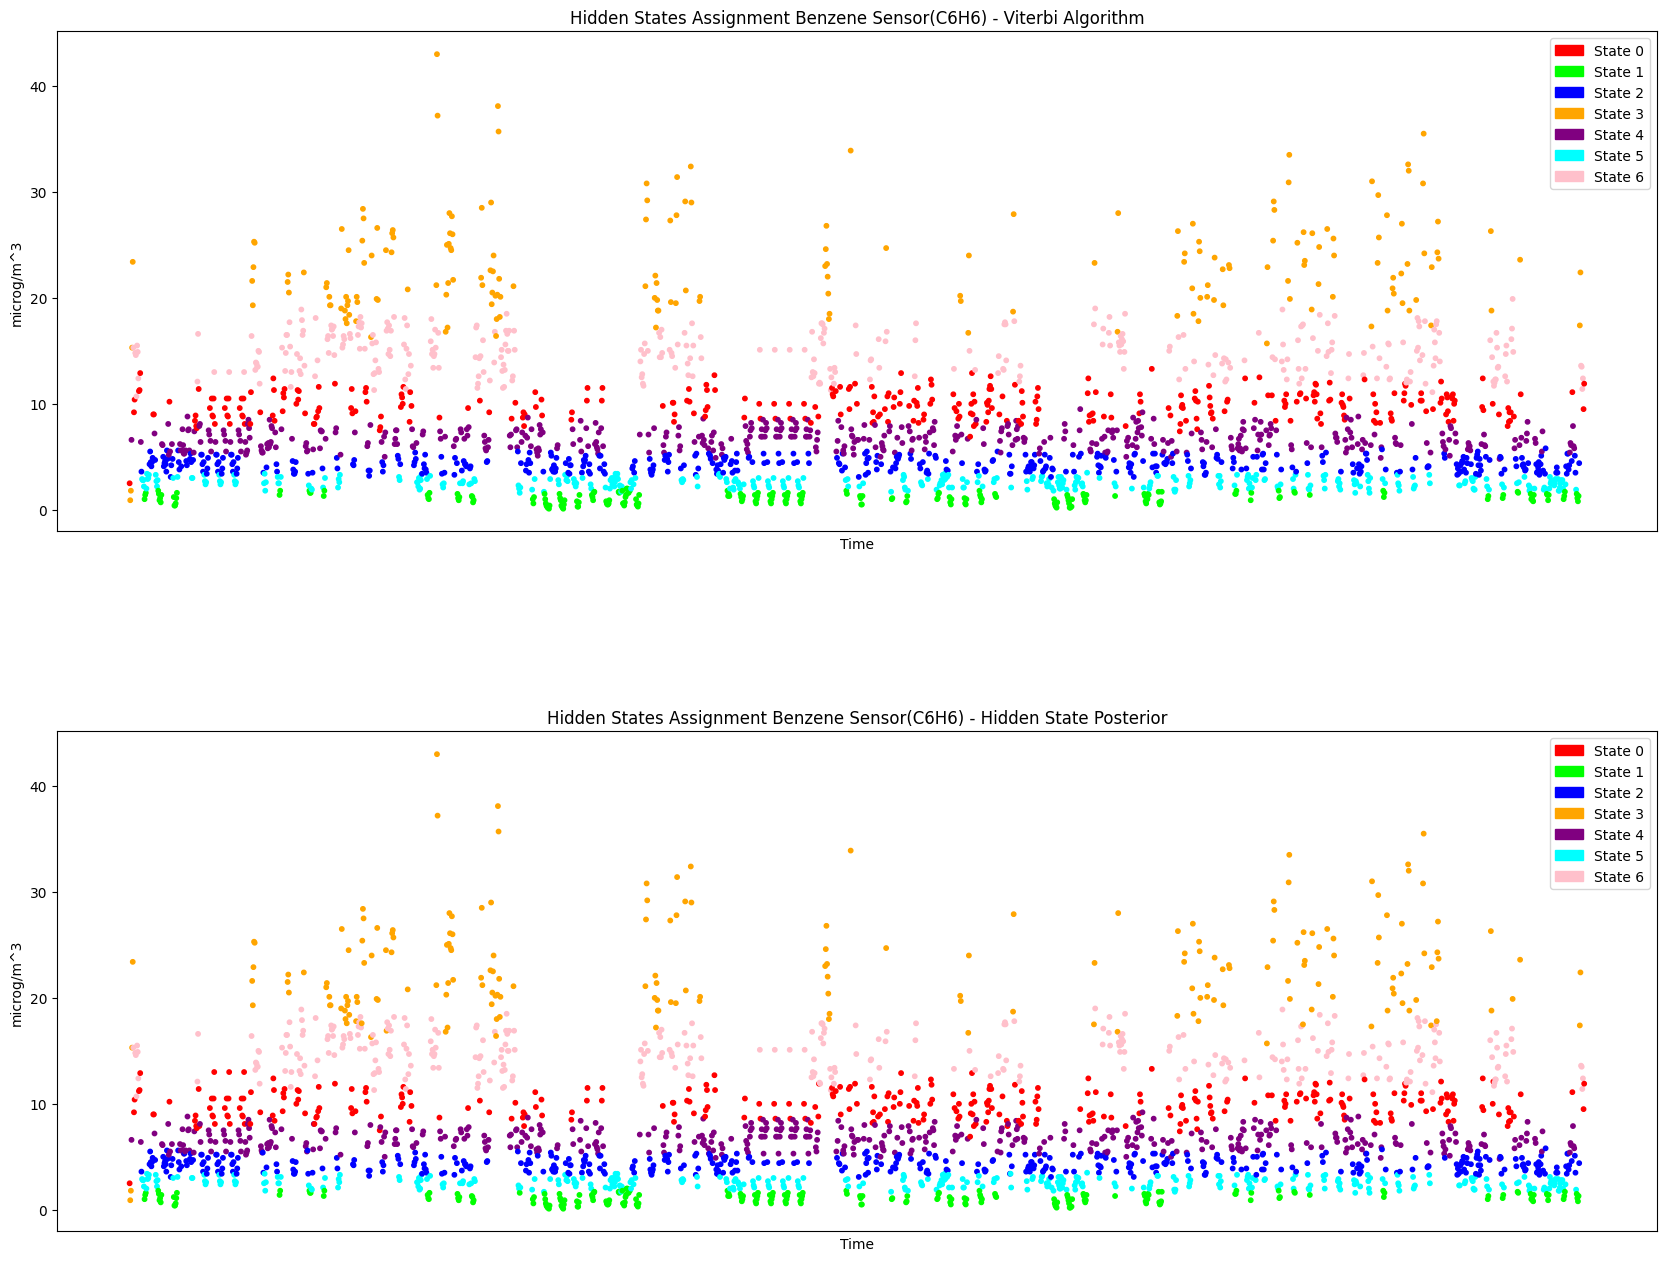

In [69]:
states = 7

color_dict = {
    0: '#FF0000', 
    1: '#00FF00', 
    2: '#0000FF', 
    3: '#FFA500',  
    4: '#800080',
    5: '#00FFFF',
    6: '#FFC0CB'
}

labels = [f'State {i}' for i in range(states)] # labels for identify which color is which state

legend = [mpatches.Patch(color=color_dict[i], label=labels[i]) for i in range(states)] # legend to show in the plot

mps_colors = []
v_colors = []
for i, c in enumerate(subseq):
  v_colors.append(color_dict[v_states[i]])
  mps_colors.append(color_dict[mps_states[i]])

# plot
fig, ax = plt.subplots(2, 1, figsize = (20,15))

ax[0].set_title("Hidden States Assignment Benzene Sensor(C6H6) - Viterbi Algorithm")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("microg/m^3")
ax[0].scatter(data.index[0: subseq_size], subseq, s=10, c=v_colors)
ax[0].legend(handles=legend)

ax[1].set_title("Hidden States Assignment Benzene Sensor(C6H6) - Hidden State Posterior")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("microg/m^3")
ax[1].scatter(data.index[0: subseq_size], subseq, s=10, c=mps_colors)
ax[1].legend(handles=legend)

ax[0].grid(False)
ax[1].grid(False)
ax[0].set_xticks([])
ax[1].set_xticks([])
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

Comment the plot with the different 'clusters'(very-high, high, medium-high, medium, medium-low, low, very-low), how similar the two plots are (maybe local dependencies).

## Appendix
Plot Transition matrix of the model

In [70]:
def plot_transition_matrix(model, n_components):
    transition_matrix = model.transmat_

    # Plot the transition matrix
    plt.figure(figsize=(6, 4))
    plt.imshow(transition_matrix, interpolation='nearest', cmap='Blues')
    plt.title(f'HMM Transition Matrix with {n_components} states')
    plt.colorbar(label='Probability')

    for i in range(transition_matrix.shape[0]):
        for j in range(transition_matrix.shape[1]):
            plt.text(j, i, '{:.4f}'.format(transition_matrix[i, j]), ha="center", fontsize=6, color='black')
    
    plt.grid(False)
    plt.xticks(np.arange(n_components), labels=np.arange(n_components))
    plt.yticks(np.arange(n_components), labels=np.arange(n_components))
    plt.xlabel('To State')
    plt.ylabel('From State')
    plt.show()

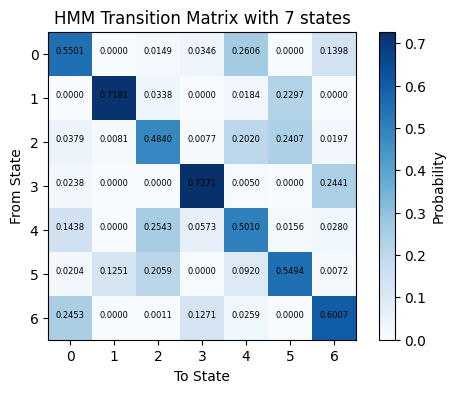

In [71]:
plot_transition_matrix(mix_gauss_model, 7)

In [72]:
for i, s_prob in enumerate(mix_gauss_model.startprob_):
    print(f'Prior Probability State {i}: {s_prob}')

Prior Probability State 0: 1.0
Prior Probability State 1: 0.0
Prior Probability State 2: 0.0
Prior Probability State 3: 0.0
Prior Probability State 4: 0.0
Prior Probability State 5: 0.0
Prior Probability State 6: 0.0


In [73]:
data['C6H6(GT)'].mean()

10.088741049481673

In [74]:
data.iloc[0]

Date        10/03/2004
Time          18.00.00
C6H6(GT)          11.9
Name: 0, dtype: object